# Hybrid Recommendation System

Combining Collaborative Filtering and Content-Based Filtering with proper score normalization.

## Import Libraries

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import json
import joblib
import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)

## Database Connection

In [81]:
DB_CONFIG = {
    'host': 'localhost',
    'port': 3306,
    'database': 'ecommerce_db',
    'user': 'root',
    'password': 'root'
}

connection_string = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
engine = create_engine(connection_string)

## Load Collaborative Filtering Model

In [82]:
print("Loading Item-Based CF model...")
try:
    cf_model = joblib.load('../models/cf_model.pkl')
    print(f"✓ CF model loaded successfully")
    print(f"   - Users: {cf_model['interaction_matrix'].shape[0]}")
    print(f"   - Products: {cf_model['interaction_matrix'].shape[1]}")
    
    # FIXED: Safely access metadata
    if 'metadata' in cf_model:
        print(f"   - Training date: {cf_model['metadata']['training_date']}")
    
    # Extract variables - FIXED: Use correct keys
    item_similarity_cf = cf_model['item_similarity']
    user_item_matrix = cf_model['user_item_matrix']
    
    print(f"✓ CF model variables extracted:")
    print(f"   - item_similarity_cf: {item_similarity_cf.shape}")
    print(f"   - user_item_matrix: {user_item_matrix.shape}")
    
except FileNotFoundError:
    print("CF model not found. Please run notebook 02_model_training.ipynb first.")
    raise
except KeyError as e:
    print(f"Missing key in CF model: {e}")
    print(f"   Available keys: {list(cf_model.keys())}")
    raise

Loading Item-Based CF model...
✓ CF model loaded successfully
   - Users: 226
   - Products: 200
   - Training date: 2025-12-31T03:37:19.144243
✓ CF model variables extracted:
   - item_similarity_cf: (200, 200)
   - user_item_matrix: (226, 200)


## Build Content-Based Model

In [83]:
query_products = """
SELECT
    p.id as product_id,
    p.name as product_name,
    p.tags,
    c.name as category_name,
    b.name as brand_name
FROM products p
LEFT JOIN categories c ON p.category_id = c.id
LEFT JOIN brands b ON p.brand_id = b.id
"""
df_products = pd.read_sql(query_products, engine)

print(f"Loaded {len(df_products)} products")

# Parse tags
df_products['tags_list'] = df_products['tags'].apply(
    lambda x: json.loads(x) if pd.notna(x) and x != '' else []
)
df_products['tags_text'] = df_products['tags_list'].apply(lambda x: ' '.join(x))

Loaded 200 products


In [84]:
print("Building Content-Based feature vectors...")

# Weights
WEIGHTS_CB = {
    'tags': 0.5,
    'category': 0.2,
    'brand': 0.2,
    'name': 0.1
}

tags_vectorizer = TfidfVectorizer(max_features=500, lowercase=True)
tags_vector = tags_vectorizer.fit_transform(df_products['tags_text'])

category_vectorizer = CountVectorizer()
category_vector = category_vectorizer.fit_transform(df_products['category_name'])

brand_vectorizer = CountVectorizer()
brand_vector = brand_vectorizer.fit_transform(df_products['brand_name'])

name_vectorizer = TfidfVectorizer(max_features=200, lowercase=True)
name_vector = name_vectorizer.fit_transform(df_products['product_name'])

combined_vector = hstack([
    tags_vector * WEIGHTS_CB['tags'],
    category_vector * WEIGHTS_CB['category'],
    brand_vector * WEIGHTS_CB['brand'],
    name_vector * WEIGHTS_CB['name']
])

print(f" Feature vectors: {combined_vector.shape}")
print(f"   Weights: {WEIGHTS_CB}")

Building Content-Based feature vectors...
 Feature vectors: (200, 625)
   Weights: {'tags': 0.5, 'category': 0.2, 'brand': 0.2, 'name': 0.1}


In [85]:
print("Calculating content similarity...")
content_similarity = cosine_similarity(combined_vector)

content_similarity_df = pd.DataFrame(
    content_similarity,
    index=df_products['product_id'],
    columns=df_products['product_id']
)

avg_sim = content_similarity[np.triu_indices_from(content_similarity, k=1)].mean()
print(f"  Content similarity matrix: {content_similarity_df.shape}")
print(f"   Average similarity: {avg_sim:.4f}")

Calculating content similarity...
  Content similarity matrix: (200, 200)
   Average similarity: 0.0367


## Compare CF vs CB Score Distributions

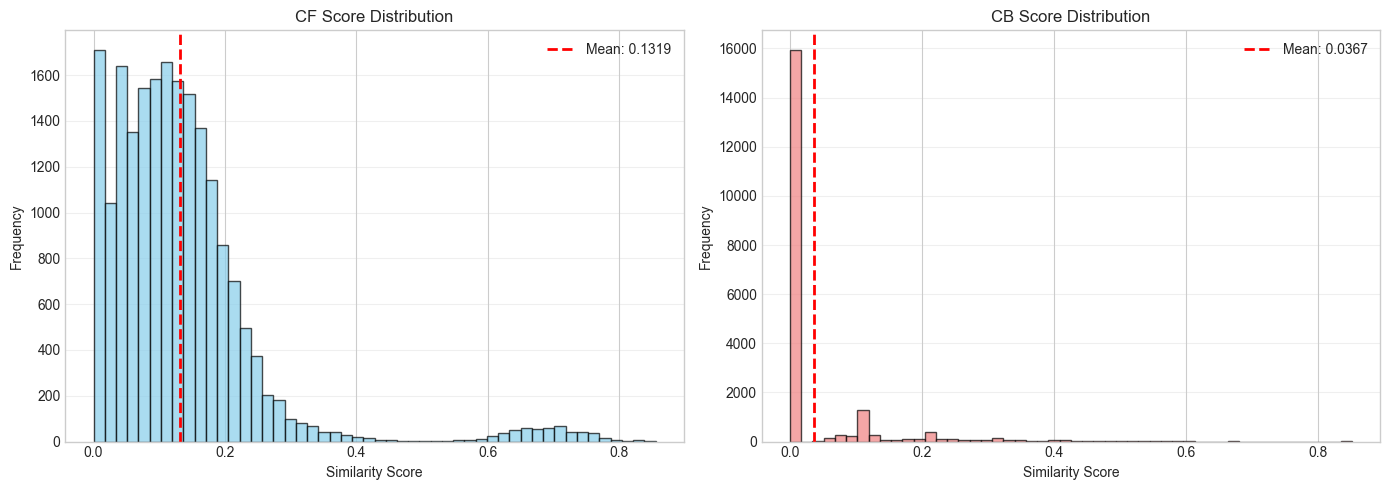

CF: Mean=0.1319, Std=0.1197
CB: Mean=0.0367, Std=0.0909
Score ratio (CF/CB): 3.59x


In [86]:
cf_scores_sample = item_similarity_cf.values[np.triu_indices_from(item_similarity_cf.values, k=1)]
cb_scores_sample = content_similarity[np.triu_indices_from(content_similarity, k=1)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(cf_scores_sample, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(cf_scores_sample.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {cf_scores_sample.mean():.4f}')
axes[0].set_xlabel('Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('CF Score Distribution')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(cb_scores_sample, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].axvline(cb_scores_sample.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {cb_scores_sample.mean():.4f}')
axes[1].set_xlabel('Similarity Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('CB Score Distribution')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"CF: Mean={cf_scores_sample.mean():.4f}, Std={cf_scores_sample.std():.4f}")
print(f"CB: Mean={cb_scores_sample.mean():.4f}, Std={cb_scores_sample.std():.4f}")
print(f"Score ratio (CF/CB): {cf_scores_sample.mean() / cb_scores_sample.mean():.2f}x")

## Score Normalization

In [87]:
def normalize_scores(scores_dict):
    """
    Min-Max normalization to [0, 1]
    """
    if not scores_dict or len(scores_dict) == 0:
        return {}

    scores_array = np.array(list(scores_dict.values()))
    min_score = scores_array.min()
    max_score = scores_array.max()

    if max_score == min_score:
        return {k: 1.0 for k in scores_dict}

    normalized = {}
    for product_id, score in scores_dict.items():
        normalized[product_id] = (score - min_score) / (max_score - min_score)

    return normalized

print("  Normalization function defined")

  Normalization function defined


## Load User Interactions

In [88]:
query_views = """
SELECT user_id, product_id, view_count
FROM user_product_views
"""
df_views = pd.read_sql(query_views, engine)

print(f"Loaded {len(df_views)} interactions")
print(f"Unique users: {df_views['user_id'].nunique()}")

Loaded 8527 interactions
Unique users: 228


## Recommendation Functions

In [89]:
def get_cf_recommendations(user_id, top_n=20):
    """Collaborative Filtering recommendations"""
    if user_id not in user_item_matrix.index:
        return {}

    user_interactions = user_item_matrix.loc[user_id]
    viewed_products = user_interactions[user_interactions > 0].index.tolist()

    if not viewed_products:
        return {}

    scores = {}
    for product_id in user_item_matrix.columns:
        if product_id in viewed_products:
            continue

        score = 0
        total_weight = 0

        for viewed_product in viewed_products:
            similarity = item_similarity_cf.loc[viewed_product, product_id]
            view_count = user_interactions[viewed_product]

            score += similarity * view_count
            total_weight += abs(similarity)

        if total_weight > 0:
            scores[product_id] = score / total_weight

    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return {prod_id: score for prod_id, score in sorted_scores}

print("  CF function defined")

  CF function defined


In [90]:
def get_cb_recommendations(user_id, top_n=20):
    """Content-Based recommendations"""
    user_views = df_views[df_views['user_id'] == user_id]
    if len(user_views) == 0:
        return {}

    viewed_products = user_views['product_id'].tolist()
    scores = {}

    for _, row in user_views.iterrows():
        product_id = row['product_id']
        view_count = row['view_count']

        if product_id in content_similarity_df.index:
            similarities = content_similarity_df.loc[product_id]

            for candidate_id in similarities.index:
                if candidate_id not in viewed_products:
                    weight = view_count / user_views['view_count'].sum()
                    scores[candidate_id] = scores.get(candidate_id, 0) + similarities[candidate_id] * weight

    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return {prod_id: score for prod_id, score in sorted_scores}

print("  CB function defined")

  CB function defined


In [91]:
def get_hybrid_recommendations(user_id, top_n=10, cf_weight=0.7, cb_weight=0.3):
    """
    Hybrid recommendations with normalization
    """
    # Get scores
    cf_scores = get_cf_recommendations(user_id, top_n=30)
    cb_scores = get_cb_recommendations(user_id, top_n=30)

    if not cf_scores and not cb_scores:
        return []

    # Normalize
    cf_scores_norm = normalize_scores(cf_scores)
    cb_scores_norm = normalize_scores(cb_scores)

    # Combine
    all_products = set(cf_scores_norm.keys()) | set(cb_scores_norm.keys())
    hybrid_scores = {}

    for product_id in all_products:
        cf_score = cf_scores_norm.get(product_id, 0)
        cb_score = cb_scores_norm.get(product_id, 0)

        hybrid_score = (cf_score * cf_weight) + (cb_score * cb_weight)

        hybrid_scores[product_id] = {
            'score': hybrid_score,
            'cf_score': cf_score,
            'cb_score': cb_score,
            'cf_raw': cf_scores.get(product_id, 0),
            'cb_raw': cb_scores.get(product_id, 0)
        }

    sorted_recs = sorted(hybrid_scores.items(), key=lambda x: x[1]['score'], reverse=True)[:top_n]

    results = []
    for product_id, scores_dict in sorted_recs:
        product_info = df_products[df_products['product_id'] == product_id].iloc[0]
        results.append({
            'product_id': product_id,
            'name': product_info['product_name'],
            'category': product_info['category_name'],
            'brand': product_info['brand_name'],
            **scores_dict
        })

    return results

print(" Hybrid function defined")
print(f"   Default weights: CF={0.7}, CB={0.3}")

 Hybrid function defined
   Default weights: CF=0.7, CB=0.3


## Test Hybrid Recommendations

In [92]:
sample_user = df_views['user_id'].iloc[0]

# User history
user_history = df_views[df_views['user_id'] == sample_user].sort_values('view_count', ascending=False).head(5)
user_history = user_history.merge(df_products, on='product_id', how='left')

print("User Viewing History:")
for _, row in user_history.iterrows():
    print(f"  • {row['product_name'][:40]:40s} ({row['category_name']:15s}) - {int(row['view_count'])} views")

print("\n" + "="*80)
print("HYBRID RECOMMENDATIONS (CF 70% + CB 30%)")
print("="*80)

hybrid_recs = get_hybrid_recommendations(sample_user, top_n=10)

for i, rec in enumerate(hybrid_recs, 1):
    print(f"\n{i:2d}. {rec['name'][:45]:45s} (Score: {rec['score']:.4f})")
    print(f"    Category: {rec['category']:15s} | Brand: {rec['brand']:15s}")
    print(f"    CF: {rec['cf_score']:.4f} (raw: {rec['cf_raw']:.4f}) | CB: {rec['cb_score']:.4f} (raw: {rec['cb_raw']:.4f})")

rec_categories = {}
for rec in hybrid_recs:
    cat = rec['category']
    rec_categories[cat] = rec_categories.get(cat, 0) + 1

print(f"\nCategory Distribution: {dict(rec_categories)}")
print(f"Unique Categories: {len(rec_categories)}")

User Viewing History:
  • Logitech G Pro X Superlight              (Gaming Mouse   ) - 15 views
  • LG UltraGear 27GN950-B                   (Monitor        ) - 15 views
  • Razer Blade 15                           (Gaming Laptop  ) - 12 views
  • AMD Ryzen 9 7950X                        (CPU            ) - 11 views
  • Razer Gigantus V2                        (Mouse Pad      ) - 6 views

HYBRID RECOMMENDATIONS (CF 70% + CB 30%)

 1. Corsair Harpoon RGB Wireless                  (Score: 0.3000)
    Category: Gaming Mouse    | Brand: Corsair        
    CF: 0.0000 (raw: 0.0000) | CB: 1.0000 (raw: 0.1329)

 2. Glorious Model O                              (Score: 0.1999)
    Category: Gaming Mouse    | Brand: Logitech G     
    CF: 0.0000 (raw: 0.0000) | CB: 0.6662 (raw: 0.1064)

 3. Razer DeathAdder V3                           (Score: 0.1673)
    Category: Gaming Mouse    | Brand: Razer          
    CF: 0.0000 (raw: 0.0000) | CB: 0.5578 (raw: 0.0978)

 4. Logitech G305 Lightspeed    

## Visualize Score Contributions

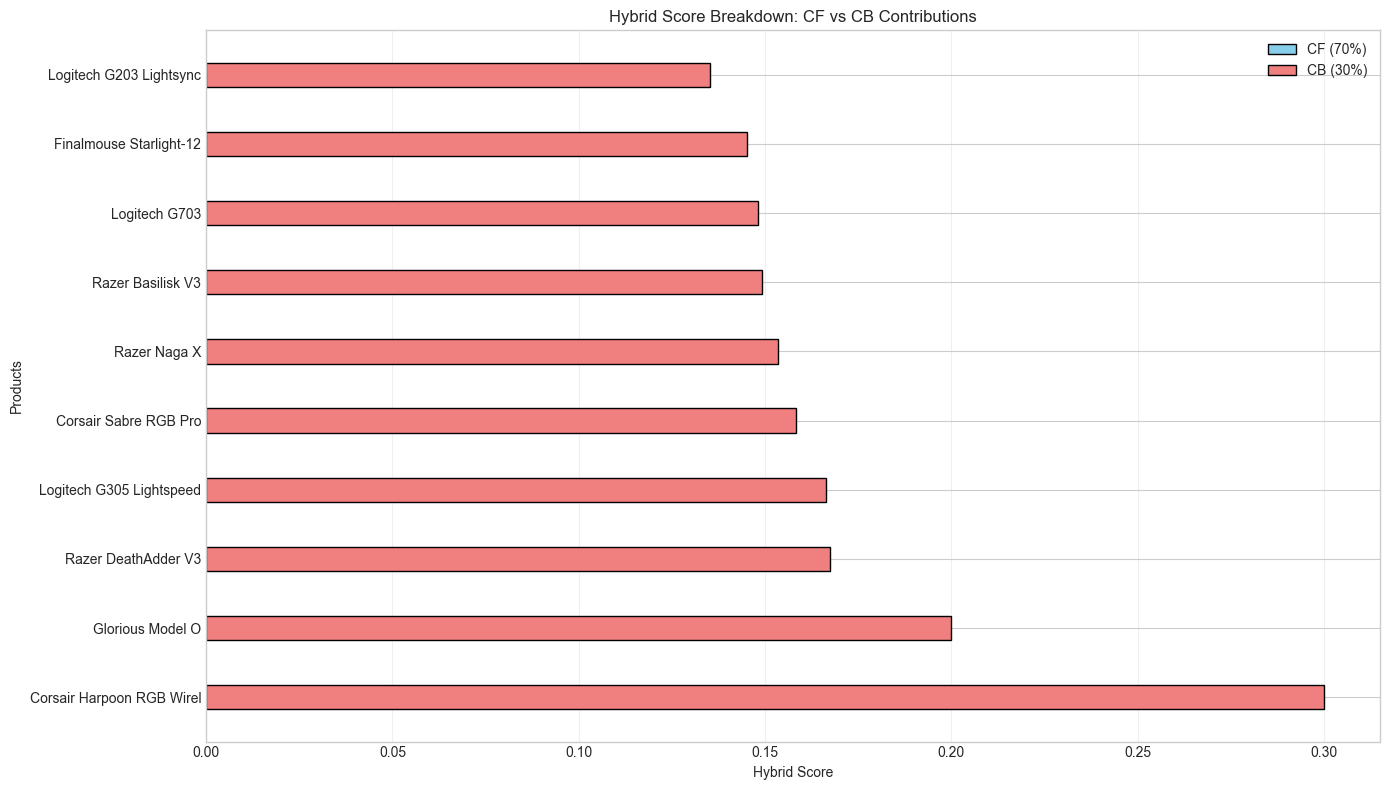

In [93]:
products = [rec['name'][:25] for rec in hybrid_recs[:10]]
cf_scores = [rec['cf_score'] * 0.7 for rec in hybrid_recs[:10]]
cb_scores = [rec['cb_score'] * 0.3 for rec in hybrid_recs[:10]]

x = np.arange(len(products))

fig, ax = plt.subplots(figsize=(14, 8))
ax.barh(x, cf_scores, 0.35, label='CF (70%)', color='skyblue', edgecolor='black')
ax.barh(x, cb_scores, 0.35, left=cf_scores, label='CB (30%)', color='lightcoral', edgecolor='black')

ax.set_ylabel('Products')
ax.set_xlabel('Hybrid Score')
ax.set_title('Hybrid Score Breakdown: CF vs CB Contributions')
ax.set_yticks(x)
ax.set_yticklabels(products)
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [94]:

# Export models for api_v2.py
import pickle
import os

print("Exporting models for production use...")

# Create models directory
os.makedirs('../ml-recommendation/models', exist_ok=True)

# Save CF model
cf_model_export = {
    'item_similarity': item_similarity_cf,
    'product_ids': list(item_similarity_cf.columns)
}
with open('../ml-recommendation/models/cf_model.pkl', 'wb') as f:
    pickle.dump(cf_model_export, f)
print("✓ Saved CF model to ml-recommendation/models/cf_model.pkl")

# Save CB model  
cb_model_export = {
    'product_similarity': content_similarity_df,
    'product_ids': list(content_similarity_df.index),
    'tfidf_tags': tags_vectorizer,
    'tfidf_names': name_vectorizer
}
with open('../ml-recommendation/models/cb_model.pkl', 'wb') as f:
    pickle.dump(cb_model_export, f)
print("✓ Saved CB model to ml-recommendation/models/cb_model.pkl")

# Save metadata
import json
from datetime import datetime

metadata = {
    'trained_at': datetime.now().isoformat(),
    'cf_weight': 0.7,
    'cb_weight': 0.3,
    'cb_feature_weights': WEIGHTS_CB,
    'num_products': len(content_similarity_df),
    'model_version': '2.0.0'
}
with open('../ml-recommendation/models/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✓ Saved metadata to ml-recommendation/models/metadata.json")

print("Models exported successfully! Ready for api_v2.py")


Exporting models for production use...
✓ Saved CF model to ml-recommendation/models/cf_model.pkl
✓ Saved CB model to ml-recommendation/models/cb_model.pkl
✓ Saved metadata to ml-recommendation/models/metadata.json
Models exported successfully! Ready for api_v2.py
